In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
import keras
print(keras.__version__)

2.5.0


In [ ]:
from tensorflow.python.client import device_lib   #GPU 확인
device_lib.list_local_devices()

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun 15 13:35:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install -U coremltools

     |████████████████████████████████| 3.4MB 30.0MB/s 
  Created wheel for attr: filename=attr-0.3.1-cp37-none-any.whl size=2458 sha256=586e639b8127de7b670176ae8d464f5481ce0ecd042cc843dda5f79255118d2e
  Stored in directory: /root/.cache/pip/wheels/f0/96/9b/1f8892a707d17095b5a6eab0275da9d39e68e03a26aee2e726
Successfully built attr


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


94773248/94765736 [==============================] - 1s 0us/step
Found 8250 images belonging to 15 classes.
Found 1050 images belonging to 15 classes.
Epoch 1/10
515/515 [==============================] - 4839s 9s/step - loss: 0.3650 - accuracy: 0.9056 - val_loss: 0.5798 - val_accuracy: 0.8067
Epoch 2/10
515/515 [==============================] - 1364s 3s/step - loss: 0.0851 - accuracy: 0.9876 - val_loss: 0.5415 - val_accuracy: 0.8135
Epoch 3/10
515/515 [==============================] - 1363s 3s/step - loss: 0.0551 - accuracy: 0.9945 - val_loss: 0.4972 - val_accuracy: 0.8337
Epoch 4/10
515/515 [==============================] - 1364s 3s/step - loss: 0.0426 - accuracy: 0.9956 - val_loss: 0.5061 - val_accuracy: 0.8433
Epoch 5/10
515/515 [==============================] - 1317s 3s/step - loss: 0.0343 - accuracy: 0.9972 - val_loss: 0.4800 - val_accuracy: 0.8433
Epoch 6/10
515/515 [==============================] - 1338s 3s/step - loss: 0.0285 - accuracy: 0.9982 - val_loss: 0.4708 - val_ac

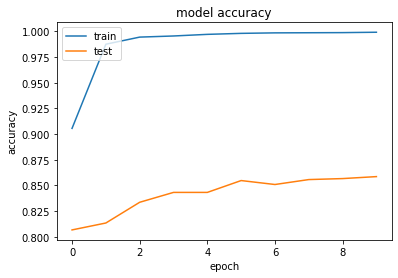

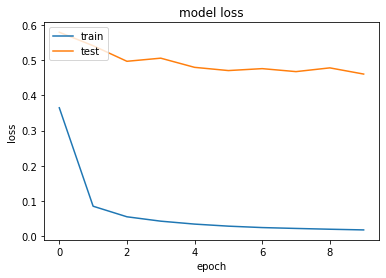

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: saved_model2/my_model/assets


In [ ]:
import numpy as np                                                                  #모델 학습 모듈 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adadelta
import keras
import math, sys
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import preprocess_input

def printGraph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

train_data_dir = '/content/drive/MyDrive/dataset/train' 
validation_data_dir = '/content/drive/MyDrive/dataset/val'

num_classes=15           #구분하려는 알약의 개수
image_size = (224, 224)
batch_size = 16
nb_epoch = 10
image_input = Input(shape=(224, 224, 3))  
opt = SGD(lr=0.01)

# create the base pre-trained model
base_model = ResNet50(input_tensor=image_input, weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable=False

#base_model.summary()
x = base_model.output             #커스텀 레이어 추가
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(base_model.input, x)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])    #모델 컴파일 (optimizer를 조정해볼까??)

num_train_samples = sum([len(files) for p, d, files in os.walk(train_data_dir)])
num_valid_samples = sum([len(files) for p, d, files in os.walk(validation_data_dir)])

num_train_steps = math.floor(num_train_samples/batch_size)
num_valid_steps = math.floor(num_valid_samples/batch_size)

#train_datagen = ImageDataGenerator(rescale=1./255.)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
#test_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=image_size,
  batch_size=batch_size,
  class_mode='categorical', shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
  validation_data_dir,
  target_size=image_size ,
  batch_size=batch_size,
  class_mode='categorical', shuffle=True
)

history = model.fit(
  train_generator,
  steps_per_epoch=num_train_steps,
  epochs=nb_epoch,
  validation_data=validation_generator,
  validation_steps=num_valid_steps,
  verbose=1)

printGraph(history)

!mkdir -p saved_model2
model.save('saved_model2/my_model')
model.save('my_model.h5')

In [ ]:
!cp -r /content/saved_model2 /content/drive/MyDrive      #save model to drive
!cp /content/my_model.h5 /content/drive/MyDrive

In [ ]:
import os                                                                         #모델 성능 테스트 모듈 (MobileDeepPill achieves an average 73.7% Top-1 accuracy and 95.6% Top-5 accuracy <2017년>)
import tensorflow as tf     
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
img_width, img_height = 28, 28
model = tf.keras.models.load_model('/content/drive/MyDrive/my_model.h5',compile = True)
model.summary()
test_data_dir='/content/drive/MyDrive/dataset/test/'
CLASSES = ["네렉손서방정", "레보트라정", "리보테인정", "바로소펜","베포탄정","벤즈날정","비타포린정","소론도정","스틸녹스정","쎄락틸정","알레그라정180", "위싹정","파모티딘정","페니라민정","후라시닐정"]

def prepare_image(path):
  test_image = image.load_img(path, target_size=image_size)
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  return test_image

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size = image_size,
    batch_size = 3,
    class_mode = 'categorical'
)


scores = model.evaluate(test_generator, verbose=2)            #전체 test set 에 대해 테스트 
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))


'''
def evaluate(pill_name):
  print(pill_name+"예측 중..")
  i=0
  for (root, dirs, files) in os.walk('/content/drive/MyDrive/dataset/test/'+pill_name): #전체 test set에 대해 하나하나 결과 보기 
    for name in files:
      f=os.path.join(root, name)
      #print(f+"예측 중..")
      test_image=prepare_image(f)
      predictions = model.predict(test_image, batch_size=1)
      #print(predictions)
      inferred=CLASSES[np.argmax(predictions)]
      #print(inferred)
      if inferred==pill_name:
        i+=1
  print(i/30*100)

for c in CLASSES:
  evaluate(c)
'''


Found 450 images belonging to 15 classes.
150/150 - 501s - loss: 0.4240 - accuracy: 0.8600
accuracy: 86.00%


'\ndef evaluate(pill_name):\n  print(pill_name+"예측 중..")\n  i=0\n  for (root, dirs, files) in os.walk(\'/content/drive/MyDrive/dataset/test/\'+pill_name): #전체 test set에 대해 하나하나 결과 보기 \n    for name in files:\n      f=os.path.join(root, name)\n      #print(f+"예측 중..")\n      test_image=prepare_image(f)\n      predictions = model.predict(test_image, batch_size=1)\n      #print(predictions)\n      inferred=CLASSES[np.argmax(predictions)]\n      #print(inferred)\n      if inferred==pill_name:\n        i+=1\n  print(i/30*100)\n\nfor c in CLASSES:\n  evaluate(c)\n'

In [1]:
import os                                                                         #모델 성능 테스트 모듈 (MobileDeepPill achieves an average 73.7% Top-1 accuracy and 95.6% Top-5 accuracy <2017년>)
import tensorflow as tf     
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
img_width, img_height = 28, 28
model = tf.keras.models.load_model('/content/drive/MyDrive/my_model.h5',compile = True)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
import os

for (root, dirs, files) in os.walk('/content/drive/MyDrive/dataset/test/소론도정/'): 
  print(files)

['IMG_6832.JPG', 'IMG_6843.JPG', 'IMG_6851.JPG', 'IMG_6853.JPG', 'IMG_6859.JPG', 'IMG_6864.JPG', 'IMG_6882.JPG', 'IMG_6884.JPG', 'IMG_6885.JPG', 'IMG_6879.JPG', 'IMG_6886.JPG', 'IMG_6889.JPG', 'IMG_6896.JPG', 'IMG_6900.JPG', 'IMG_6891.JPG', 'IMG_6892.JPG', 'IMG_6906.JPG', 'IMG_6910.JPG', 'IMG_6918.JPG', 'IMG_6917.JPG', 'IMG_6925.JPG', 'IMG_6920.JPG', 'IMG_6923.JPG', 'IMG_6928.JPG', 'IMG_6924.JPG', 'IMG_6931.JPG', 'IMG_6932.JPG', 'IMG_6936.JPG', 'IMG_6939.JPG', 'IMG_6943.JPG']


In [ ]:
import os                                                                         #모델 성능 테스트 모듈 (MobileDeepPill achieves an average 73.7% Top-1 accuracy and 95.6% Top-5 accuracy <2017년>)
import tensorflow as tf     
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
img_width, img_height = 28, 28
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model2/my_model',compile = True)
#new_model.summary()
test_data_dir='/content/drive/MyDrive/dataset/test/'
CLASSES = ["네렉손서방정", "레보트라정", "리보테인정", "바로소펜","베포탄정","벤즈날정","비타포린정","소론도정","스틸녹스정","쎄락틸정","알레그라정180", "위싹정","파모티딘정","페니라민정","후라시닐정"]

def prepare_image(path):
  test_image = image.load_img(path, target_size=image_size)
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  return test_image

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size = image_size,
    batch_size = 3,
    class_mode = 'categorical'
)

count=0
name='벤즈날정'

for (root, dirs, files) in os.walk('/content/drive/MyDrive/dataset/test/'+name): #전체 test set에 대해 하나하나 결과 보기 
  for name in files:
    f=os.path.join(root, name)
    print(f+"예측 중..")
    test_image=prepare_image(f)
    predictions = model.predict(test_image, batch_size=1)
    print(predictions)
    print(CLASSES[np.argmax(predictions)])

Found 450 images belonging to 15 classes.
/content/drive/MyDrive/dataset/test/벤즈날정/20210604_215358.jpg예측 중..
[[0.01205199 0.2879565  0.01257671 0.00760753 0.00934826 0.56632864
  0.00302619 0.01475246 0.01825507 0.02712299 0.0016731  0.00444393
  0.01128792 0.02166378 0.00190491]]
벤즈날정
/content/drive/MyDrive/dataset/test/벤즈날정/20210604_215430.jpg예측 중..
[[2.59279041e-03 5.19874752e-01 4.46316641e-04 2.95739505e-03
  1.38147431e-03 4.63183045e-01 1.14884104e-04 2.31150858e-04
  1.33001755e-04 4.43252781e-03 5.84596637e-05 1.05786603e-03
  3.58862570e-04 2.87409732e-03 3.03361128e-04]]
레보트라정
/content/drive/MyDrive/dataset/test/벤즈날정/20210604_215439.jpg예측 중..
[[0.01311811 0.3161574  0.00519147 0.00306886 0.02985234 0.5593982
  0.00332848 0.00640136 0.00261688 0.01627117 0.00154035 0.01798799
  0.01371255 0.00989544 0.00145944]]
벤즈날정
/content/drive/MyDrive/dataset/test/벤즈날정/20210604_215535.jpg예측 중..
[[1.1049430e-02 1.4571404e-01 5.1750951e-03 6.3333618e-03 2.7888760e-02
  7.4494582e-01 2.6739

In [ ]:
import os
for (root, dirs, files) in os.walk('/content/drive/MyDrive/test2'):
  print(dirs)
  '''
   for name in files:
      s=os.path.join(root, name)
      print(s)
  '''

['네렉손서방정', '소론도정', '후라시닐정', '비타포린정', '베포탄정']
[]
[]
[]
[]
[]
